In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
landmarks_frame = pd.read_csv('DITS-full\DITS-full\DITS-detection\class\classes.csv')

n = 1
img_name = 'DITS-full\DITS-full\DITS-detection\class\image\\'+landmarks_frame.iloc[0, 0]
landmarks = landmarks_frame.iloc[n, 1]

print('Image name: {}'.format(img_name))
print('Type: {}'.format(landmarks))


Image name: DITS-full\DITS-full\DITS-detection\class\image\0.png
Type: 0


In [3]:
class StreetSignDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        # Carica le landmarks come array NumPy e assicurati che abbiano sempre dimensioni consistenti
        landmarks = np.array(str(self.landmarks_frame.iloc[idx, 1]).split(), dtype=np.float32)

        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        if len(landmarks) > 0:
            landmarks = landmarks - np.array([left, top])

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        landmarks = np.array(landmarks, dtype=np.float32)  # Converti landmarks in un array NumPy
        
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [8]:
tran= transforms.Compose([Rescale(256),ToTensor()])

In [9]:
sign_dataset = StreetSignDataset('DITS-full\DITS-full\DITS-detection\class\classes.csv','DITS-full\DITS-full\DITS-detection\class\image',tran)

fig = plt.figure()

for i, sample in enumerate(sign_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 256, 266]) torch.Size([2])
1 torch.Size([3, 256, 259]) torch.Size([2])
2 torch.Size([3, 256, 261]) torch.Size([2])
3 torch.Size([3, 256, 261]) torch.Size([2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
Landmarks shape for sample 0: torch.Size([2])
Reshaped landmarks shape for sample 0: torch.Size([1, 2])
Landmarks shape for sample 1: torch.Size([2])
Reshaped landmarks shape for sample 1: torch.Size([1, 2])
Landmarks shape for sample 2: torch.Size([2])
Reshaped landmarks shape for sample 2: torch.Size([1, 2])
Landmarks shape for sample 3: torch.Size([2])
Reshaped landmarks shape for sample 3: torch.Size([1, 2])


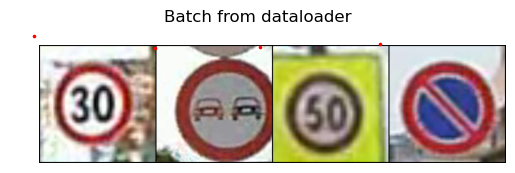

In [7]:
dataloader = DataLoader(sign_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
        sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        print(f"Landmarks shape for sample {i}: {landmarks_batch[i].shape}")
        landmarks = landmarks_batch[i].view(-1, 2)  # Reshape per renderli bidimensionali
        print(f"Reshaped landmarks shape for sample {i}: {landmarks.shape}")
        plt.scatter(landmarks[:, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks[:, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

    plt.title('Batch from dataloader')


# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break